# B.2. Commodity Futures

## FX, Futures, and Equity

### DRW New-Hire Learning Program

#### Summer 2022
 
Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from utils import *
from portfolio import *

In [2]:
LOADFILE = '../data/futures_data.xlsx'

# Definition

A futures contract is an agreement
* entered at $t$
* to purchase an asset at $T$
* for a price $F$

It is an obligation, not an option!

We will return to some key differences between futures and forwards.


### Assets

Futures contracts are an important way to trade commodities including
* energy
* metals
* grains
* livestock

Futures contracts are traded widely on many assets beyond commodities:
* interest-rate products
* currency
* equity indexes
* other indexes

### Settlement

Settlement may be via
* delivery of the asset
* cash payment equal to the spot price of the asset

In [3]:
futures_info = pd.read_excel(LOADFILE,sheet_name='futures contracts').set_index('symbol')
futures_info

,bb ticker,name,type,category,delivery type,exchange,contract date,contract size,contract value,crncy,margin limit,tick size,tick value,open interest,volume,volume 10d avg
symbol,,,,,,,,,,,,,,,,
CL,CLA Comdty,WTI CRUDE FUTURE Aug22,Physical commodity future.,Crude Oil,PHYS,New York Mercantile Exchange,2022-08-01,1000,103210.0,USD,8350.0,0.010,10.00,176736,30884,366608.5
NG,NGA Comdty,NATURAL GAS FUTR Aug22,Physical commodity future.,Natural Gas,PHYS,New York Mercantile Exchange,2022-08-01,10000,61910.0,USD,7700.0,0.001,10.00,85417,2598,107210.4
GC,GCA Comdty,GOLD 100 OZ FUTR Aug22,Physical commodity future.,Precious Metal,PHYS,"Commodity Exchange, Inc.",2022-08-01,100,174000.0,USD,7200.0,0.100,10.00,360981,17235,189638.9
AH,LAA Comdty,LME PRI ALUM FUTR Jul22,Physical commodity future.,Base Metal,PHYS,London Metal Exchange,2022-07-01,25,60887.5,USD,NaN,0.010,0.25,37554,442,12501.5
KC,KCA Comdty,COFFEE 'C' FUTURE Sep22,Physical commodity future.,Foodstuff,PHYS,ICE Futures US Softs,2022-09-01,37500,82087.5,USD,9000.0,0.050,18.75,101075,15350,17316.5
ZC,C A Comdty,CORN FUTURE Dec22,Physical commodity future.,Corn,PHYS,Chicago Board of Trade,2022-12-01,5000,30100.0,USD,2300.0,0.250,12.50,568770,10530,161184.2
LE,LCA Comdty,LIVE CATTLE FUTR Aug22,Physical commodity future.,Livestock,PHYS,Chicago Mercantile Exchange,2022-08-01,40000,53820.0,USD,1600.0,0.025,10.00,99455,23969,26257.6
HE,LHA Comdty,LEAN HOGS FUTURE Aug22,Physical commodity future.,Livestock,CASH,Chicago Mercantile Exchange,2022-08-01,40000,43800.0,USD,1900.0,0.025,10.00,55247,25067,20161.5
ES,ESA Index,S&P500 EMINI FUT Sep22,Physical index future.,Equity Index,CASH,Chicago Mercantile Exchange,2022-09-01,50,194450.0,USD,10500.0,0.250,12.50,2279397,58054,1735525.7


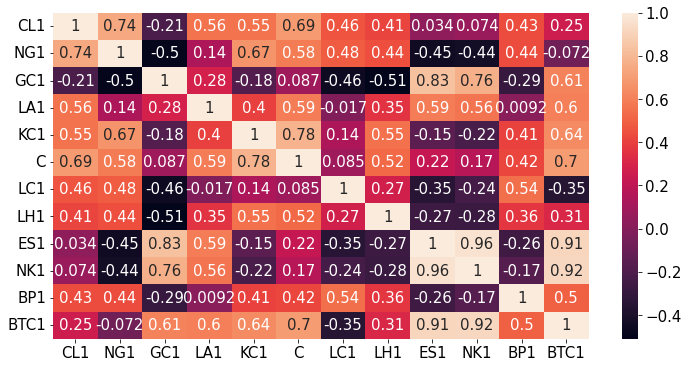

In [4]:
ADJLAB = 'roll=ratio'
futures_hist = pd.read_excel(LOADFILE,sheet_name=f'continuous futures {ADJLAB}').set_index('date')
corrmat = futures_hist.loc['2015':,:].corr()
sns.heatmap(corrmat,annot=True);

# Trading

## Exchanges

**Futures** trade on exchanges. In U.S. markets, the following two exchanges are of particular note:

* Chicago Mercantile Exchange (CME)
* Intercontinental Exchange (ICE)

In recent years, the trading has moved to being overwhelmingly (and at many exchanges, completely,) electronic.

### Standardization
One role of an exchange is to standardize the trading, which allows for better liquidity.

This is especially useful in commodities, to set the grade, size, location of the asset.

### Clearing
As part of trading on an exchange, futures are **centrally cleared.** This is important for 
* eliminating counterparty risk
* achieving better netting and margin requirements

## Quoting Conventions

https://www.cmegroup.com/markets/energy/crude-oil/light-sweet-crude.contractSpecs.html

### Multiple

### Tick Size

### Open Interest

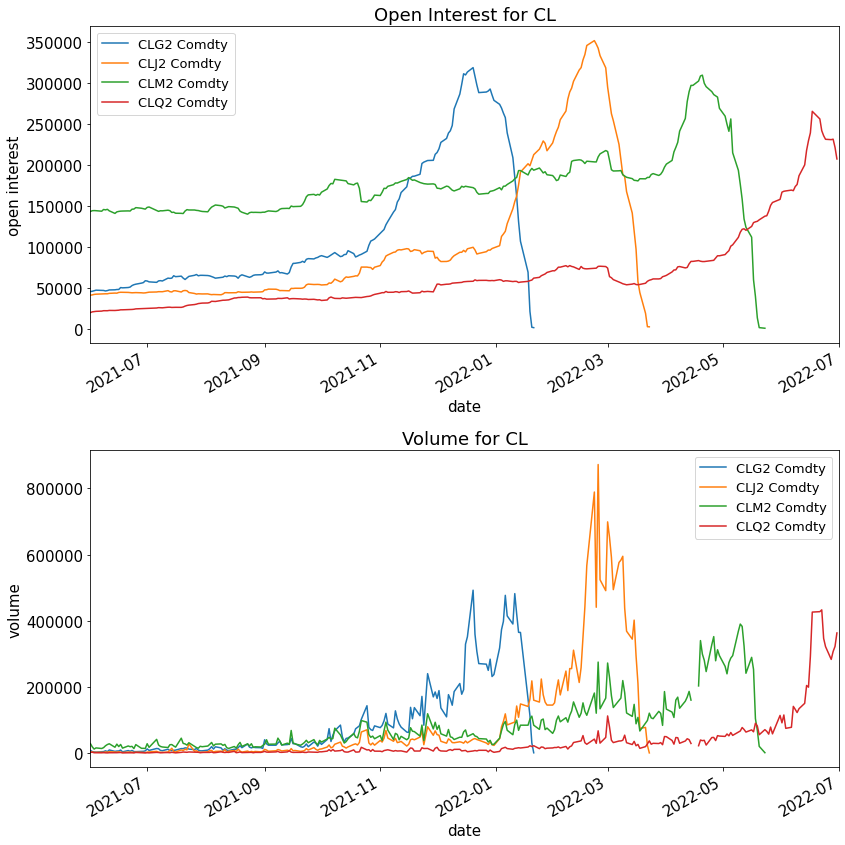

In [5]:
TICKS = ['CL','GC']

futures_ts = pd.read_excel(LOADFILE,sheet_name='futures timeseries',header=[0,1,2]).droplevel(2,axis=1)
futures_ts.set_index(futures_ts.columns[0],inplace=True)
futures_ts.index.name = 'date'
futures_ts = futures_ts.swaplevel(axis=1)

fig, ax = plt.subplots(2,1,figsize=(12,12))
futures_ts['OPEN_INT'].iloc[:,0:4].plot(ax=ax[0],xlim=('2021-06','2022-07'),title=f'Open Interest for {TICKS[0]}',ylabel='open interest')
futures_ts['VOLUME'].iloc[:,0:4].plot(ax=ax[1],xlim=('2021-06','2022-07'),title=f'Volume for {TICKS[0]}',ylabel='volume')
plt.tight_layout()
plt.show()

# Pricing

## Forward Price
The basic model of a futures price is:
$$F_0 = S_0 e^{r_f T}$$
This equation is derived by no-arbitrage, in a simplified setting of
* no market frictions
* a constant risk-free rate, $r_f$
* no financing considerations (margin, marking to market, etc)

This is just the **forward pricing** equation.

It says that the futures price should be the spot price compounded by the risk-free rate until delivery.

## Carry
The pricing formula above accounts for the time-value of money, but it does not account for the **carry** cost of the asset.

### Dividend yield
Suppose that the asset pays a dividend yield of $q$
* dividends on stock index
* lease rate on metals

### Storage cost
The asset may be costly to store, such that it has a negative carry.
* oil, grains, etc

### Carry
Let **carry**, $c$, denote the net difference of the storage costs minus income.

Then,
$$F_0 = S_0 e^{(r_f+c)T}$$

That is, the 
* higher the storage costs, the **higher** the futures price.
* higher the income, the **lower** the futures price.

## Convenience Yield

For consumption assets, the no-arbitrage argument is more complicated.
$$F_0 < S_0e^{(r_f+c)T}$$
This is due to the fact that the asset has a **convenience yield**, $y$.

This convenience yield is not explicit income to the owner, but rather potential income should the consumption use of the asset be important during the contract period.

The equation can make explicit note of this,
$$F_0 = S_0e^{(r_f+c-y)T}$$
or simply include the convenience yield as part of the carry.
$$F_0 = S_0e^{(r_f+c^*)T}$$

## Frictions

## Optionality

### Wild card

### Cheapest to deliver

## Difference to Forwards

### Credit risk

### Liquidity

### Marking to Market

In [6]:
marg = futures_info[['name']].copy()
marg['margin limit %'] = futures_info['margin limit']/futures_info['contract value']

px = futures_hist.copy()
px[px<0] = np.nan
rx = px.pct_change().dropna()

marg['vol'] = rx.std().values
marg['margin sigma'] = marg['margin limit %'] / marg['vol']
marg.set_index('name',inplace=True)
marg.index = [' '.join(row.split()[:-2]) for row in marg.index]

marg.dropna().sort_values('margin sigma').style.format({'margin limit %':'{:.1%}','vol':'{:.1%}','margin sigma':'{:.1f}'})

,margin limit %,vol,margin sigma
LEAN HOGS,4.3%,2.3%,1.9
WTI CRUDE,8.1%,3.5%,2.3
LIVE CATTLE,3.0%,1.1%,2.7
NATURAL GAS,12.4%,3.8%,3.3
S&P500 EMINI,5.4%,1.3%,4.1
GOLD 100 OZ,4.1%,0.9%,4.4
BP CURRENCY,2.7%,0.6%,5.0
CORN,7.6%,1.5%,5.2
COFFEE 'C',11.0%,2.0%,5.4
CME Bitcoin,28.9%,4.7%,6.2


# The Curve

## Backwardation and Contango

In [7]:
list_curves = ['CL1','GC1']
curves = dict()
for comdty in list_curves:
    curves[comdty]= pd.read_excel(LOADFILE,sheet_name=f'curve {comdty}')

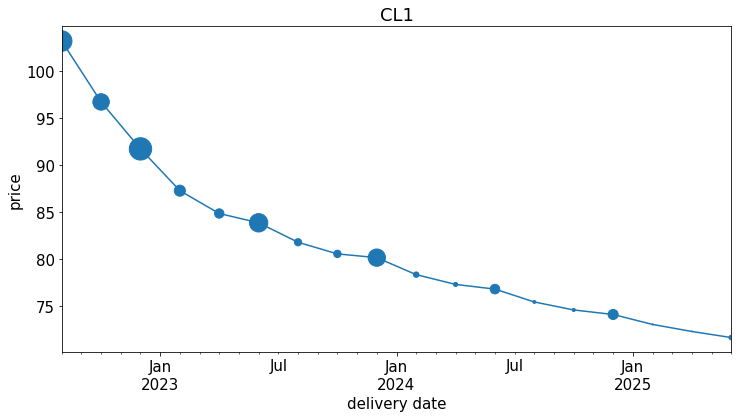

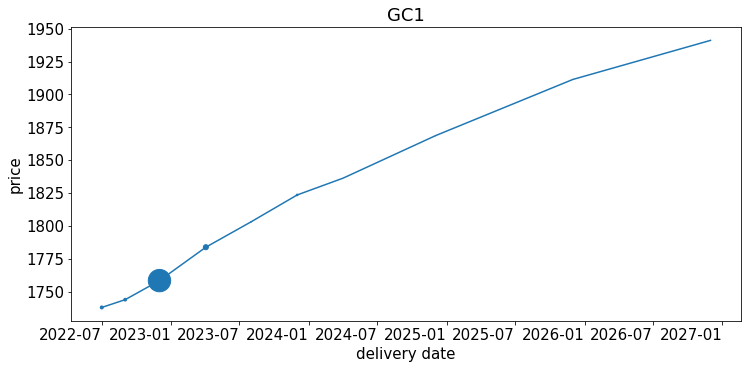

In [8]:
for comdty in list_curves:
    
    temp = curves[comdty].set_index('delivery date').sort_index()
    msize = (temp['open interest']/temp['open interest'].max()) * 500
    
    fig, ax=plt.subplots()
    temp['price'].plot(ax=ax,marker=None,title=comdty)
    temp.reset_index().plot.scatter('delivery date','price',s=msize,ax=ax,title=comdty)
    plt.show()

## Roll

<AxesSubplot:xlabel='date'>

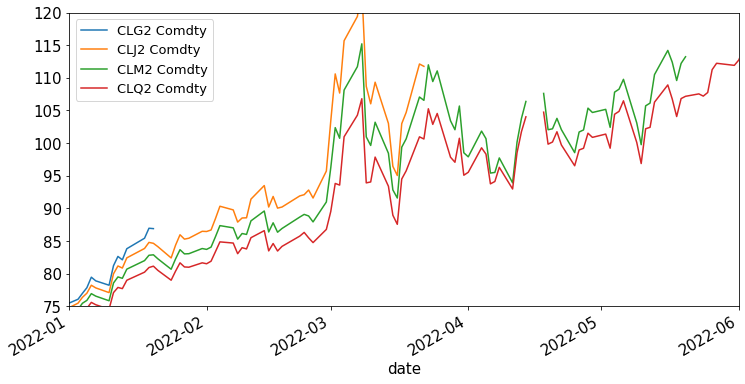

In [9]:
futures_ts['LAST_PRICE'].iloc[:,0:4].plot(xlim=('2022-01','2022-06'),ylim=(75,120))

## Continuous Contract

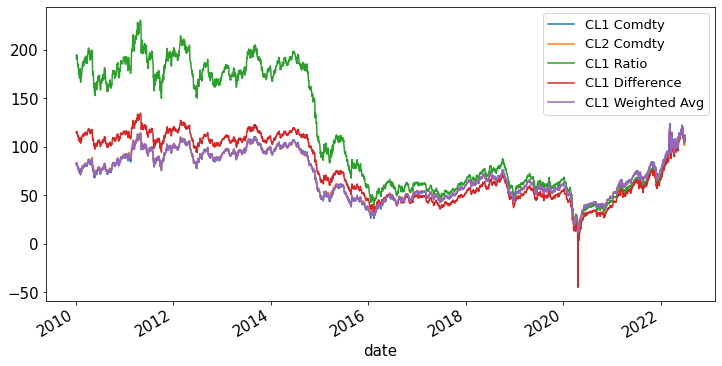

In [10]:
TICK = 'CL'
data_comp = pd.read_excel(LOADFILE,sheet_name=f'roll conventions {TICK}').set_index('date')
data_comp.plot();

### Performance across roll methods

In [13]:
px = data_comp.copy()
px[px<0] = np.nan
px[px==np.inf] = np.nan
rx_comp = px.pct_change()
performanceMetrics(rx_comp,annualization=252).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
CL1 Comdty,12.1%,44.2%,27.4%,-45.2%,37.7%
CL2 Comdty,11.9%,45.9%,25.9%,-43.4%,78.8%
CL1 Ratio,5.0%,43.2%,11.5%,-45.2%,25.1%
CL1 Difference,19.4%,61.6%,31.5%,-73.2%,73.2%
CL1 Weighted Avg,10.9%,41.9%,26.1%,-30.7%,24.4%


### Performance of Continuous Futures

In [12]:
performanceMetrics(rx,annualization=252).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
CL1,28.3%,56.2%,50.3%,-45.2%,25.1%
NG1,30.0%,60.5%,49.6%,-16.5%,46.5%
GC1,6.8%,15.0%,45.6%,-5.0%,5.9%
LA1,3.3%,21.4%,15.3%,-7.6%,5.6%
KC1,12.8%,32.3%,39.7%,-8.6%,10.0%
C,18.3%,23.4%,78.4%,-6.8%,6.4%
LC1,-0.4%,17.4%,-2.1%,-5.1%,5.6%
LH1,4.2%,36.2%,11.6%,-9.3%,10.1%
ES1,9.8%,20.9%,46.7%,-10.4%,9.8%
NK1,7.6%,20.3%,37.5%,-7.4%,7.8%
